## Modelo GARCH
$\varepsilon_t \sim \mathcal{N}\left(0,\sigma_t \right)$

$\sigma_t = \sqrt{\omega+\alpha_1\sigma_{t-1}^2+\alpha_2\sigma_{t-2}^2...\alpha_q\sigma_{t-p}^2+\beta_1\varepsilon_{t-1}^2+\beta_2\varepsilon_{t-2}^2...+\beta_p\varepsilon_{t-q}^2} = \sqrt{\omega+\sum_{i = 1}^{p}\alpha_i\sigma_{t-i}^2+\sum_{i = 1}^{q}\beta_{t-i}^2}$

In [1]:
setwd("C:/Users/User/Documents/Meus Arquivos/Códigos")
source("Funções.R")

In [2]:
options(warn = -1, scipen = 999)
pacotes <- c("tidyquant", "tidyverse","corrplot","wesanderson")
for(i in pacotes){
    suppressPackageStartupMessages({
        library(i, character.only = T)
    })
}

In [3]:
#Ações escolhidas
acoes <- acoes <- c("TRPL4.SA","ITSA4.SA","ABEV3.SA","ENAT3.SA","B3SA3.SA")
reta <- tq_get(acoes, from = "2010-01-01") %>%
  mutate(adjusted = abs(adjusted)) %>%
  group_by(symbol) %>%
  tq_transmute(select = adjusted, mutate_fun = dailyReturn) %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit
datas <- reta$date

In [4]:
#Transformando em série temporal
reta_ts <- xts(reta[,2:ncol(reta)], order.by = datas)

In [5]:
lista <- suppressMessages(apply(reta_ts,2,find_best_arch_model,c("sGARCH"),
                                c("snorm","std"),max_lag_MA = 1,max_lag_AR = 1,2,2,
                                min_GARCH = 1,
                               min_ARCH = 1))
multi <- replicate(ncol(reta_ts),list())

In [6]:
for(i in 1:length(lista)){
  multi[[i]] <- lista[[i]]$ugspec_b
}

In [7]:
multspec <- multispec(multi)
multf <- multifit(multispec = multspec, data = reta_ts)
multfor <- multiforecast(multf, n.ahead = 2)

In [8]:
best <- suppressMessages(find_best_dcc_model(reta_ts, uspec = multspec, dist_to_use = c("mvnorm","mvt")))
spec1 <- best$dccspec_b

In [9]:
fit1 <- dccfit(spec1, data = reta_ts, fit = multf, fit.control = list(eval.se = T))
fore <- dccforecast(fit = fit1, n.ahead = 2)

In [10]:
#Usando o µ como retorno esperado
coefs <- numeric(length = ncol(reta_ts))
for(i in 1:length(coefs)){
  coefs[i] <- multf@fit[[i]]@fit$coef["mu"]*252
}

In [11]:
#Matriz de covariância
cov1 <- rcov(fit1)
cov <- cov1[,,dim(cov1)[3]]
cov_f <- rcov(fore)
cov_f <- cov_f[[1]]
cov_f1 <- cov_f[1:ncol(reta_ts),1:ncol(reta_ts),1]
cov_f2 <- cov_f[1:ncol(reta_ts),1:ncol(reta_ts),2]

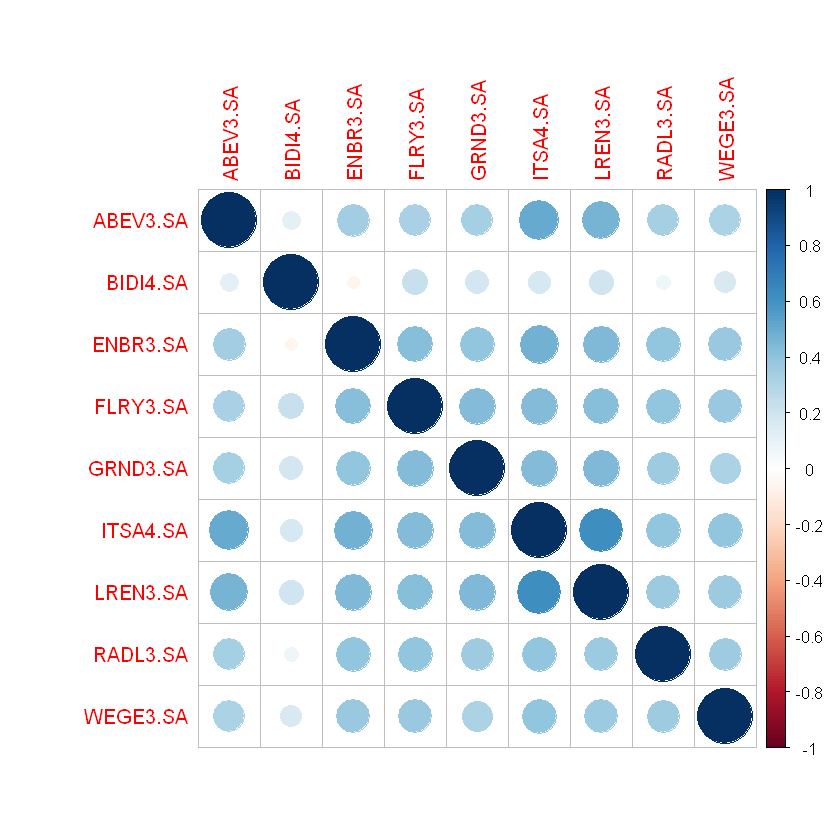

In [12]:
correlacao <- rcor(fore)[[1]][,,2]
corrplot(correlacao)

In [13]:
#Desvio das ações
sd <- sqrt(diag(cov))
sd_f1 <- sqrt(diag(cov_f1))
sd_f2 <- sqrt(diag(cov_f2))
sd_a <- sd*sqrt(252)
sd_a_f1 <- sd_f1*sqrt(252)
sd_a_f2 <- sd_f2*sqrt(252)

In [14]:
#Data.frame
retorno_med <- data.frame(coefs, sd_a_f2)
colnames(retorno_med) <- c("Retorno","Risco")
rownames(retorno_med) <- colnames(reta_ts)
retorno_med$Retorno <- coefs

In [15]:
#Nº de simulações de carteiras a se fazer
n_sim <- 500000
pesos <- pesos_carteira(n_acoes = ncol(reta_ts), n_sim = n_sim, short = F)

## Risco e retorno de uma carteira
$\sigma_c = \sqrt{\begin{vmatrix}\omega_1 & \omega_2 & \cdots \end{vmatrix} * \begin{vmatrix}\sigma^2_{1} & \cdots & \sigma_{1,n} \\ \vdots & \ddots & \vdots \\ \sigma_{n,1} & \cdots & \sigma^2_{n} \end{vmatrix} * \begin{vmatrix}\omega_1 \\ \omega_2 \\ \vdots \end{vmatrix}}$

$\mu_c = \sum_{i}\omega_i\mu_i$

In [16]:
#Escolha se prefere o risco atual ou a previsão de risco para 1 período (sd ou sd_f)
start <- Sys.time()
riscos <- apply(pesos, 2, portfolio_sd_t, cov = cov_f2)*sqrt(252)
riscos <- riscos %>% as.matrix
retornos <- apply(pesos, 2, portfolio_return, returns = retorno_med$Retorno) %>% as.matrix
colsub <- apply(riscos,1,function(x)!is.nan(x))
riscos <- riscos[colsub]
retornos <- retornos[colsub]
end <- Sys.time()
end-start

Time difference of 24.63826 secs

## Sharpe
$S = \frac{\mu_c-\mu_r}{\sigma_c}$ onde $\mu_c$ é o retorno da carteira, $\mu_r$ o retorno do ativo livre de risco e $\sigma_c$ é o desvio-padrão da carteira

In [17]:
#Sharpe
tx_livre_risco <- 0.0025
data <- matrix(0, nrow = 3, ncol = length(riscos))
data[1,] <- retornos
data[2,] <- riscos
data[3,] <- (retornos-tx_livre_risco)/riscos
rownames(data) <- c("Retornos", "Riscos","Sharpe")
pesos <- pesos[,colsub]
data_d <- as.data.frame(t(data))

In [18]:
#Dados Simulados
sharpe <- max(data[3,])
names(sharpe) <- "Sharpe Máximo"
Ret_max <- max(data[1,])
names(Ret_max) <- "Retorno Máximo"
sd_min <- min(data[2,])
names(sd_min) <- "Risco Mínimo"
sharpe
Ret_max
sd_min

Sharpe Máximo 
     1.953054

Retorno Máximo 
       0.69621

Risco Mínimo 
   0.2149995

In [19]:
#Melhor carteira (Venda a descoberto)
otimo <- otimizacao(coefs, cov_f2, tx_livre_risco, short = T)
pesos_otimo <- otimo$Weights
ret_otimo <- otimo$Return
sd_otimo <- otimo$Sd*sqrt(252)
sharpe_otimo <- (ret_otimo-tx_livre_risco)/sd_otimo
data_otimo <- data.frame(Retorno = ret_otimo, Risco = sd_otimo, Sharpe = sharpe_otimo)
componente_m_o <- componente_risco(ret = coefs,cov = cov_f2, weights = pesos_otimo, percent = F)
componente_m_o

$Marginal
         ABEV3.SA  BIDI4.SA    ENBR3.SA    FLRY3.SA    GRND3.SA    ITSA4.SA
[1,] -0.004368056 0.0105238 0.006870529 0.007739246 0.001947197 0.004780857
        LREN3.SA    RADL3.SA  WEGE3.SA
[1,] 0.009337643 0.007288702 0.0185563

$Contribution
        ABEV3.SA    BIDI4.SA    ENBR3.SA     FLRY3.SA      GRND3.SA
[1,] 0.001772805 0.001309307 0.003660054 0.0007719615 -0.0005137251
          ITSA4.SA     LREN3.SA     RADL3.SA  WEGE3.SA
[1,] -0.0002432275 0.0000748004 0.0007819722 0.0157429

$Return_contribution
                 [,1]
ABEV3.SA  0.065262196
BIDI4.SA  0.049259859
ENBR3.SA  0.138163970
FLRY3.SA  0.029109369
GRND3.SA -0.019865330
ITSA4.SA -0.009220317
LREN3.SA  0.002816461
RADL3.SA  0.029502471
WEGE3.SA  0.590673933

In [20]:
#Dados da carteira ótima (com possível venda a descoberto)
data_otimo
print(pesos_otimo, 3)

Retorno,Risco,Sharpe
<dbl>,<dbl>,<dbl>
0.8757026,0.3707785,2.355052


ABEV3.SA BIDI4.SA ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA RADL3.SA 
-0.40586  0.12441  0.53272  0.09975 -0.26383 -0.05088  0.00801  0.10729 
WEGE3.SA 
 0.84839 


In [21]:
#Melhor carteira 
otimo_s <- otimizacao(coefs, cov_f2, tx_livre_risco, short = F)
pesos_otimo_s <- otimo_s$Weights
ret_otimo_s <- otimo_s$Return
sd_otimo_s <- otimo_s$Sd*sqrt(252)
sharpe_otimo_s <- (ret_otimo_s-tx_livre_risco)/sd_otimo_s
data_otimo_s <- data.frame(Retorno = ret_otimo_s, Risco = sd_otimo_s, Sharpe = sharpe_otimo_s)
#Contribuição dos ativos em % para o risco
componente_m_s <- componente_risco(ret = coefs,cov = cov_f2, weights = pesos_otimo_s, percent = F)
componente_m_s

$Marginal
       ABEV3.SA  BIDI4.SA    ENBR3.SA    FLRY3.SA   GRND3.SA   ITSA4.SA
[1,] 0.01109881 0.0125507 0.008193793 0.009931224 0.00837524 0.01065364
       LREN3.SA  RADL3.SA   WEGE3.SA
[1,] 0.01887491 0.0092997 0.02213025

$Contribution
     ABEV3.SA     BIDI4.SA    ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA
[1,]        0 0.0009445528 0.002047662        0        0        0        0
     RADL3.SA   WEGE3.SA
[1,]        0 0.01493433

$Return_contribution
               [,1]
ABEV3.SA 0.00000000
BIDI4.SA 0.02979768
ENBR3.SA 0.06481428
FLRY3.SA 0.00000000
GRND3.SA 0.00000000
ITSA4.SA 0.00000000
LREN3.SA 0.00000000
RADL3.SA 0.00000000
WEGE3.SA 0.46984434

In [22]:
#Dados da melhor carteira (sem possível venda)
data_otimo_s
print(pesos_otimo_s, digits = 3)

Retorno,Risco,Sharpe
<dbl>,<dbl>,<dbl>
0.5644563,0.2845751,1.974721


ABEV3.SA BIDI4.SA ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA RADL3.SA 
  0.0000   0.0753   0.2499   0.0000   0.0000   0.0000   0.0000   0.0000 
WEGE3.SA 
  0.6748 


In [23]:
#Melhor carteira simulada
positivo <- data[3,] == sharpe
show(data[,positivo])
pesos_efi <- round(pesos[,positivo],3)
names(pesos_efi) <- colnames(reta_ts)
print(pesos_efi)

 Retornos    Riscos    Sharpe 
0.5889488 0.3002727 1.9530540 
ABEV3.SA BIDI4.SA ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA RADL3.SA 
   0.001    0.080    0.135    0.006    0.012    0.000    0.003    0.031 
WEGE3.SA 
   0.733 


In [24]:
#Menor Risco
menor <- port_min_risk(coefs, cov_f2)
menor_risco <- menor$Weights
ret_men_risco <- menor$Return
sd_men_risco <- menor$Sd*sqrt(252)
sharpe_men_risco <- (ret_men_risco-tx_livre_risco)/sd_men_risco
data_men <- data.frame(Retorno = ret_men_risco, Risco = sd_men_risco, Sharpe = sharpe_men_risco)
compo_m <- componente_risco(ret = coefs,cov = cov_f2, weights = menor_risco, percent = F)
compo_m

$Marginal
       ABEV3.SA   BIDI4.SA   ENBR3.SA   FLRY3.SA   GRND3.SA   ITSA4.SA
[1,] 0.01270482 0.01270482 0.01270482 0.01270482 0.01270482 0.01270482
       LREN3.SA   RADL3.SA   WEGE3.SA
[1,] 0.01270482 0.01270482 0.01270482

$Contribution
         ABEV3.SA   BIDI4.SA    ENBR3.SA     FLRY3.SA    GRND3.SA    ITSA4.SA
[1,] 0.0003490219 0.00112944 0.006936918 0.0007495819 0.001682946 0.001205063
        LREN3.SA    RADL3.SA    WEGE3.SA
[1,] -0.00173055 0.001163612 0.001218792

$Return_contribution
                 [,1]
ABEV3.SA -0.004417463
BIDI4.SA  0.035198040
ENBR3.SA  0.141610474
FLRY3.SA  0.017218140
GRND3.SA  0.009974158
ITSA4.SA  0.017190171
LREN3.SA -0.047890852
RADL3.SA  0.025185858
WEGE3.SA  0.066790582

In [25]:
#Menor risco calculado (com short)
data_men
print(menor_risco, digits = 3)

Retorno,Risco,Sharpe
<dbl>,<dbl>,<dbl>
0.2608591,0.2016828,1.281017


ABEV3.SA BIDI4.SA ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA RADL3.SA 
  0.0275   0.0889   0.5460   0.0590   0.1325   0.0949  -0.1362   0.0916 
WEGE3.SA 
  0.0959 


In [26]:
#Fronteira eficiente (com venda a descoberto)
ymin <- min(coefs,retornos)-0.1
ymax <- max(data_otimo$Retorno,coefs,retornos)+0.1
rsb <- seq(ymin,ymax,l = 2000)
fronteira <- matrix(0, nrow = length(rsb), ncol = 2)
for(i in 1:length(rsb)){
  oti <- portfront(coefs, cov_f2, rsb[i])
  fronteira[i,1] <- rsb[i]
  fronteira[i,2] <- oti$Sd*sqrt(252)
}
fronteira <- data.frame(Retorno = fronteira[,1], Risco = fronteira[,2])

In [27]:
#Carteira com menor risco simulado
me <- which.min(data[2,])
pesos_m <- round(pesos[,me],3)
names(pesos_m) <- colnames(reta_ts)
show(data[,me])
print(pesos_m)

 Retornos    Riscos    Sharpe 
0.2989044 0.2149995 1.3786281 
ABEV3.SA BIDI4.SA ENBR3.SA FLRY3.SA GRND3.SA ITSA4.SA LREN3.SA RADL3.SA 
   0.004    0.091    0.613    0.017    0.055    0.015    0.002    0.118 
WEGE3.SA 
   0.086 


In [28]:
retorno_med

,Retorno,Risco
,<dbl>,<dbl>
ABEV3.SA,-0.16080105,0.4785006
BIDI4.SA,0.39593511,0.6591115
ENBR3.SA,0.25935670,0.2468939
FLRY3.SA,0.29183396,0.3480611
GRND3.SA,0.07529651,0.3403674
ITSA4.SA,0.18123370,0.3557768
LREN3.SA,0.35159047,0.6693364
RADL3.SA,0.27499024,0.3652962
WEGE3.SA,0.69623278,0.3626738


In [29]:
#Correlação entre a melhor carteira calculada e a melhor carteira simulada
corre_s <- (t(pesos_otimo) %*% cov_f2 %*% pesos_efi)/(data[2,positivo]*sd_otimo/252)
colnames(corre_s) <- "Correlação"
corre_s

Correlação
0.829514


In [30]:
#Pesos nas melhores carteiras
cov_m <- matrix(c(data[2,positivo]^2/252, t(pesos_otimo) %*% cov_f2 %*% pesos_efi,
                  t(pesos_otimo) %*% cov_f2 %*% pesos_efi, sd_otimo^2/252), byrow = T,
                nrow = 2)
inve <- solve(cov_m)
p <- inve %*% (c(data[1,positivo], data_otimo$Retorno)-tx_livre_risco)/
  sum(inve %*% (c(data[1,positivo], data_otimo$Retorno)-tx_livre_risco))
rownames(p) <- c("Simulado", "Calculado")
colnames(p) <- "Distribuição das carteiras"
p    

,Distribuição das carteiras
Simulado,-0.0008314208
Calculado,1.0008314208


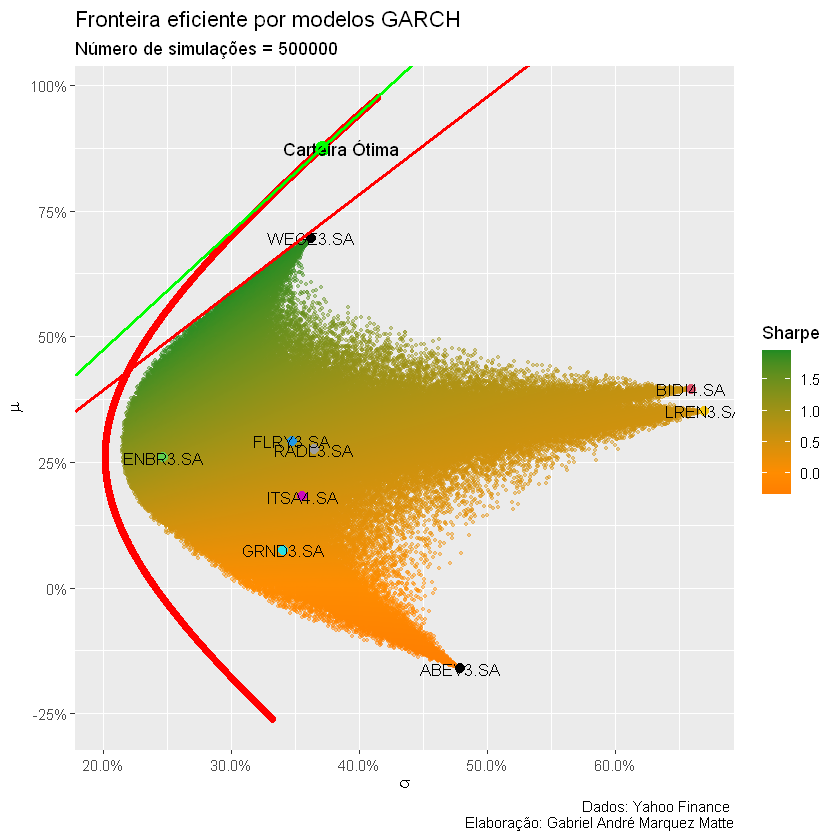

In [31]:
ggplot()+
  geom_point(data = fronteira, aes(x = Risco, y = Retorno), col = "red")+
  geom_point(data = data_d, mapping = aes(x = Riscos, y = Retornos, col = Sharpe), size = 0.7, alpha = 0.4)+
  geom_point(data = retorno_med, aes(x = Risco, Retorno), col = 1:nrow(retorno_med), size = 2.5)+
  geom_text(data = retorno_med, aes(x = Risco, Retorno, label = colnames(reta_ts)),
            size = 3.5)+
  geom_point(data = data_otimo, aes(x = Risco, y = Retorno), col = "green", size = 4)+
  geom_text(data = data_otimo, aes(x = Risco+0.015, Retorno, label = "Carteira Ótima"))+
  geom_abline(slope = max(data[3,]), intercept = tx_livre_risco, col = "red", size = 1)+
  geom_abline(slope = data_otimo[1,3], intercept = tx_livre_risco, col = "green", size = 1)+
  scale_colour_gradient2(low = "red", high = "forestgreen", mid = "darkorange")+
  labs(x = expression(sigma), y = expression(mu), title = "Fronteira eficiente por modelos GARCH",
       subtitle = paste("Número de simulações =",ncol(pesos)),
       caption = "Dados: Yahoo Finance \nElaboração: Gabriel André Marquez Matte")+
  scale_y_continuous(labels = scales::percent,
                     limits = c(min(fronteira$Retorno,retornos,coefs), max(fronteira$Retorno,coefs,retornos)))+
  scale_x_continuous(labels = scales::percent,
                     limits = c(min(fronteira[,2],riscos,sd_a_f2), max(sd_a_f2,fronteira[,2],riscos)))